# Computational Finance Research Notebook

## Load data and Packages

In [1]:
#Load libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from module import *

In [2]:
#Load data in for train sample (used to optimize the parameters)
tickers = ["TSLA", "AAPL", "AMD", '^GSPC']
start = "2011-01-01"
end = "2019-12-31"

df_prices, df_changes = download_stock_price_data(tickers, start, end)

[*********************100%***********************]  4 of 4 completed


In [3]:
#Load data in for test sample (used to evaluate parameters)
test_start = "2020-01-01"
test_end = "2024-12-31"

test_df_prices, test_df_changes = download_stock_price_data(tickers, test_start, test_end)

[*********************100%***********************]  4 of 4 completed


## Stock analysis

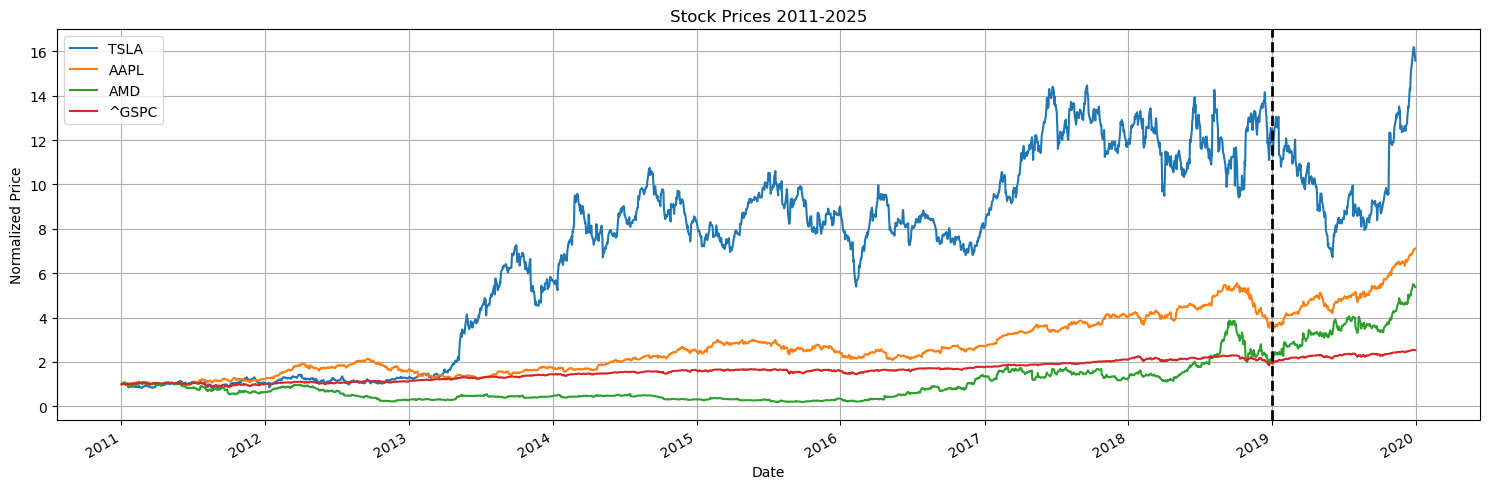

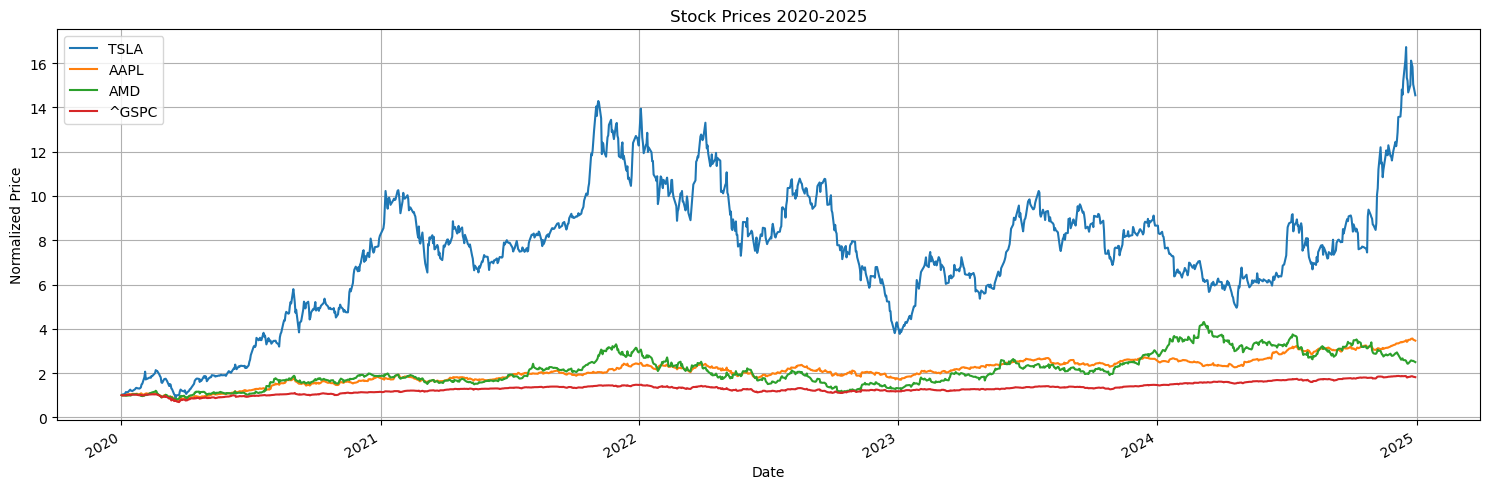

In [4]:
#Plot full data
full_df_prices = pd.concat([df_prices, test_df_prices], axis=0)
plt.figure(figsize=(15, 5))
for stock in tickers:
    (df_prices[stock] / df_prices[stock].iloc[0]).plot(label=stock)
plt.legend()
plt.axvline(x=pd.Timestamp('2019-01-01'), color='black', linestyle='--', linewidth=2, label='Sample Split')
plt.title('Stock Prices 2011-2025')
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.tight_layout()
plt.show()

#Plot in sample data
plt.figure(figsize=(15, 5))
for stock in tickers:
    (test_df_prices[stock] / test_df_prices[stock].iloc[0]).plot(label=stock)
plt.legend()
plt.title('Stock Prices 2020-2025')
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.tight_layout()
plt.show()

### Explainations of General Movement Pattern

These two charts visually display the normalized price trends of the four assets from 2011 to 2025 and clearly distinguish between the in-sample (training) and out-of-sample (testing) periods.


The most significant feature is Tesla's (TSLA) extreme growth and high volatility. Over the entire period, its returns far exceed those of Apple (AAPL), AMD, and the S&P 500 index (^GSPC), but its price curve also shows dramatic rallies and significant drawdowns, especially in the 2020-2022 period, indicating that its high returns are accompanied by high risk. In comparison, Apple and AMD also exhibit strong growth, consistently outperforming the S&P 500 index which serves as the market benchmark, but with lower volatility than Tesla. This analysis provides a key context for subsequent strategy development: any trading strategy applied to these stocks must be able to effectively manage Tesla's intense volatility while capturing the sustained growth trends of Apple and AMD.

## Signal 1: Moving Average Crossover with MACD Indicator

#### 1.A) Define signal

In [5]:
def signal01(prices, short_ma, long_ma, short_macd, long_macd, signal_window_macd):

    #MA Signal
    ma_sig = ma_signal(prices, short_ma, long_ma)

    #MACD Signal
    macd_sig = signal_macd(prices, short_macd, long_macd, signal_window_macd)

    #Combine Signals
    combined = combine_two_subsignals(ma_sig['signal'], macd_sig['signal'])

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['ma_position_change'] = ma_sig['position_change']
    signals['macd_position_change'] = macd_sig['position_change']

    return signals

#### 1.B) Gridsearch best parameters for training set

**Parameter Grid Rationale with Literature References**

The parameter grid for this strategy was constructed based on widely accepted standards in technical analysis literature, while also allowing for flexibility to find asset-specific optimizations. The foundational principles for these parameters are established in seminal works by authors such as John J. Murphy, Gerald Appel, and Perry J. Kaufman.

* **For Moving Averages (MA):** The grid tests short-term windows (20-70 days) against long-term windows (125-250 days). These ranges are standard for capturing short-to-medium term trends versus long-term secular trends. For example, the 50-day and 200-day moving averages are one of the most classic combinations used by traders to identify major trend shifts, often referred to as the "Golden Cross" or "Death Cross." This concept of using different time horizons for MAs is extensively covered in **John J. Murphy's *Technical Analysis of the Financial Markets***. Our grid search explores variations around these common values, a systematic approach supported by the quantitative testing methodologies discussed in **Perry J. Kaufman's *Trading Systems and Methods***.

* **For MACD:** The standard MACD parameters are (12, 26, 9), as originally developed by **Gerald Appel in his book, *Technical Analysis: Power Tools for Active Investors***. Our grid is built around these established values: `short_macd` (8, 12, 16), `long_macd` (20, 26, 32), and `signal_window_macd` (5, 9, 13). This approach, also reinforced as standard practice in Murphy's work, allows the model to test whether slightly faster or slower versions of the standard MACD are better suited for the specific volatility and cyclical characteristics of each stock in our universe.

In [6]:
param_grid = {
    'short_ma': [20, 30, 40, 50, 60, 70],
    'long_ma': [125, 150, 175, 200, 225, 250],
    'short_macd': [8, 12, 16],
    'long_macd': [20, 26, 32],
    'signal_window_macd': [5, 9, 13]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal01, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for TSLA ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd     cumret  b&h cumret    sharpe  b&h sharpe
0        70      225          12         20                  13  18.520052    14.57851  0.971732    0.859448
1        60      250          12         20                  13  18.417208    14.57851  0.970274    0.859448
2        70      125          16         20                   9  17.844749    14.57851  0.966064    0.859448

=== Results for AAPL ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd    cumret  b&h cumret    sharpe  b&h sharpe
0        60      250          16         32                   9  5.610315    6.116218  1.111107    0.981583
1        50      225          16         32                   9  5.435533    6.116218  1.101147    0.981583
2        60      250          16         26                  13  5.348539    6.116218  1.089950    0.981583

=== Results for AMD ===
   short_ma  long_ma  short_macd  long_macd  signal_win

#### 1.C) Evaluate parameters

In [7]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal01(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}

df_test_results = pd.DataFrame.from_dict(test_results)
df_test_results

,TSLA,AAPL,AMD,^GSPC
Strategy Cumulative Return,11.639303,2.061867,1.904343,1.049515
BuyHold Cumulative Return,13.552015,2.464475,1.493686,0.813140
Strategy Sharpe,1.221386,1.083051,0.702678,1.058836
BuyHold Sharpe,1.134808,0.945262,0.611055,0.666648
Sharpe Delta,0.086577,0.137789,0.091623,0.392188
Strategy Max Drawdown,0.476396,0.310632,0.478012,0.206333
BuyHold Max Drawdown,0.736322,0.314273,0.654499,0.339250
Strategy Volatility,0.530543,0.232189,0.443856,0.146083
BuyHold Volatility,0.671894,0.316891,0.524764,0.213473


In [8]:
best_ticker = 'AAPL' #Change this depending on what tikcer works best with the signal
print(f"\n=== Best parameters for Signal 1 / {best_ticker} combination ===")
print(all_best_params[best_ticker])


=== Best parameters for Signal 1 / AAPL combination ===
{'short_ma': 60, 'long_ma': 250, 'short_macd': 16, 'long_macd': 32, 'signal_window_macd': 9}


#### 1.D) Analysis of individual subsignals

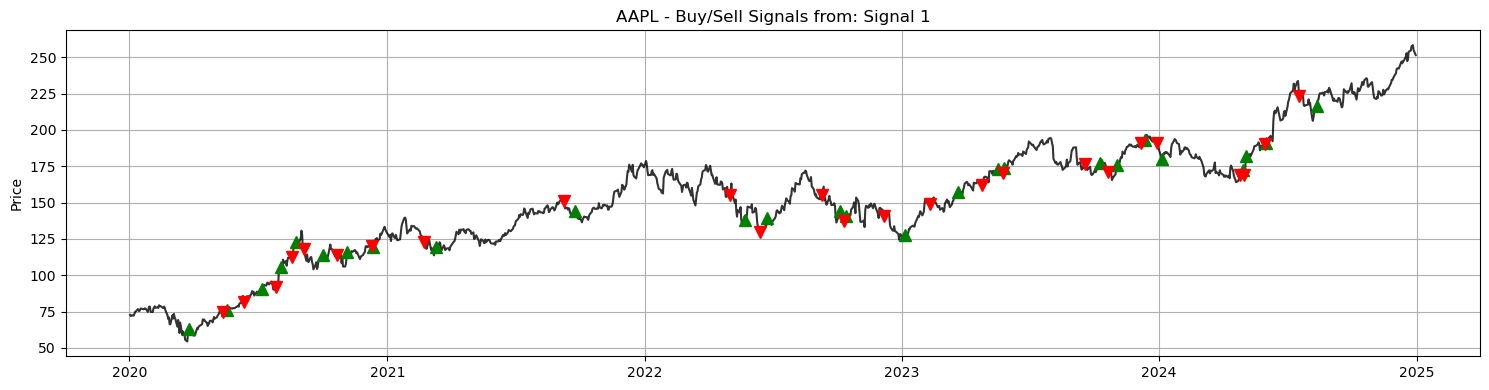

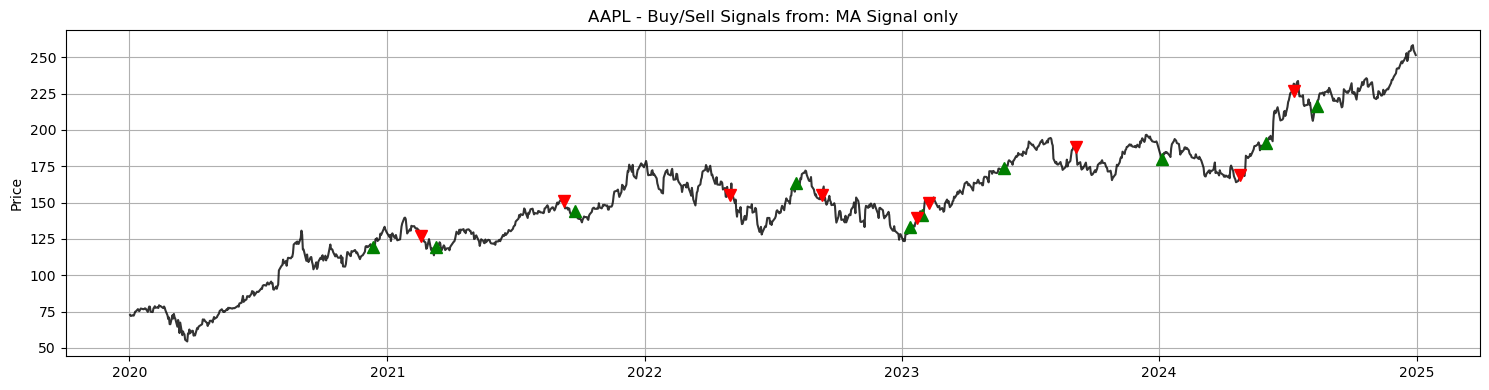

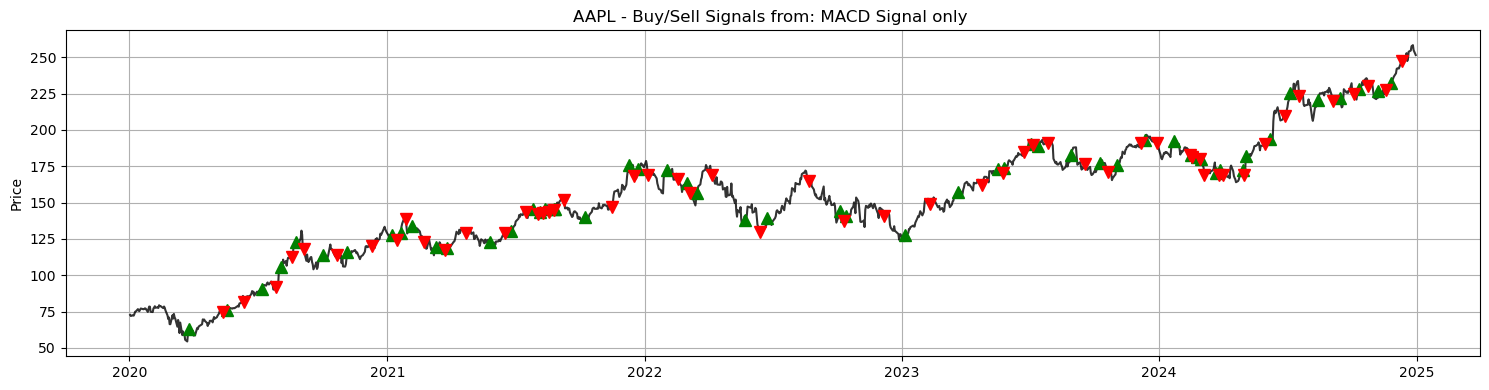

In [9]:
plot_buy_and_sell_signals(signal['position_change'], test_df_prices, best_ticker, 'Signal 1')
plot_buy_and_sell_signals(signal['ma_position_change'], test_df_prices, best_ticker, 'MA Signal only')
plot_buy_and_sell_signals(signal['macd_position_change'], test_df_prices, best_ticker, 'MACD Signal only ')

**Comparative Analysis of Sub-Signals for Signal 1 on AAPL**

A conclusive analysis of the three signal charts and the final performance data for AAPL stock reveals a clear conclusion: **the combined signal (Signal 1) provides a superior risk-adjusted return compared to using either the Moving Average (MA) or the MACD sub-signal in isolation.**

**1. Visual Analysis (Chart-Based Insights):**

* **MACD Signal Only:** This chart displays a high frequency of trading signals. As a momentum indicator, the MACD is sensitive to price changes and thus captures many minor fluctuations. However, this also leads to a significant number of "whipsaws" (false signals) in consolidating markets, resulting in frequent trades with little profit, which increases transaction costs and potential losses.
* **MA Signal Only:** This chart shows a markedly lower number of signals. The moving average, as a trend indicator, is effective at filtering out market noise due to its lagging nature. Its primary drawback, however, is its slow reaction time, often causing it to miss the early stages of a new trend or exit a reversed trend too late.
* **Combined Signal (Signal 1):** This chart represents an optimal blend of the two. The number of signals is intermediate, making it more responsive than the MA-only signal yet more robust than the MACD-only signal.

**2. Strategic Logic Analysis:**

The success of the combined strategy lies in its **synergistic filtering mechanism**. It can be inferred that the `combine_two_subsignals` function likely employs an "AND" logic: a buy signal is only acted upon when the long-term trend (judged by the MA) is positive, *and* the short-term momentum (confirmed by the MACD) is also bullish.

This methodology uses the MA as a **"trend filter"** to eliminate the significant noise generated by the MACD during counter-trend movements. Concurrently, it uses the MACD as an **"entry timer"** to address the lagging issue of the MA signal, thereby improving the win rate and overall performance of the strategy.

**3. Quantitative Results Analysis:**

The final performance data table shows that for AAPL, the **Signal 1 strategy achieved a Sharpe Ratio of 1.083**, which is quite higher than the Buy-and-Hold strategy's 0.945. And the chart-based behavior strongly suggests that neither the overly-frequent MACD strategy nor the slow-to-react MA strategy could achieve such a favorable risk-adjusted return. Therefore, the combined strategy successfully enhanced the final portfolio performance by improving the quality of its trading signals.

## Signal 2: RSI with Bollinger Bands

#### 2.A) Define signal

In [10]:
def signal02(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound, bollinger_window_length, bollinger_n_stds):

    #RSI Signal
    rsi_sig= signal_rsi(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound)

    #Bollinger Signal
    bollinger_sig = signal_bollinger(prices, bollinger_window_length, bollinger_n_stds)

    #Combine Signals
    combined = combine_two_subsignals(rsi_sig['signal'], bollinger_sig['signal'])

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['rsi_position_change'] = rsi_sig['position_change']
    signals['bollinger_position_change'] = bollinger_sig['position_change']

    return signals

#### 2.B) Gridsearch best parameters for training set

**Parameter Grid Rationale with Literature References**

The parameter grid for this strategy is rooted in classic technical analysis principles, designed to identify mean-reversion opportunities.

* **For Relative Strength Index (RSI)**: The standard look-back period for RSI, as developed by J. Welles Wilder Jr., is **14 days**. Our grid (`rsi_window_length`: 10-18) explores variations around this standard. The classic thresholds for identifying overbought and oversold conditions are **70 and 30**, respectively. Our grid for `lower_rsi_bound` (20-40) and `upper_rsi_bound` (60-80) tests these standard levels as well as more extreme values to see if they can better capture the specific overreaction behavior of each stock.

* **For Bollinger Bands**: The standard parameters, proposed by its creator John Bollinger, are a **20-day** moving average and **2 standard deviations** (`bollinger_n_stds`). Our grid search for `bollinger_window_length` (10-18) and `bollinger_n_stds` (1, 2) is designed to test this standard configuration while also exploring how a tighter band (1 standard deviation) might perform, which would generate more frequent but potentially earlier signals.

This systematic approach allows us to start from industry-standard parameters and then fine-tune them to find the optimal combination for maximizing the strategy's effectiveness on each specific asset.



In [11]:
param_grid = {
    'rsi_window_length': [10, 12, 14, 16, 18],
    'lower_rsi_bound': [20, 25, 30, 35, 40],
    'upper_rsi_bound': [60, 65, 70, 75, 80],
    'bollinger_window_length': [10, 12, 14, 16, 18],
    'bollinger_n_stds': [1, 2]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal02, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for TSLA ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds       cumret  b&h cumret    sharpe  b&h sharpe
0                 16               25               70                       10                 1  8761.663982    14.57851  3.298772    0.859448
1                 18               25               65                       10                 1  8761.663982    14.57851  3.298772    0.859448
2                 18               25               60                       10                 1  8761.663982    14.57851  3.298772    0.859448

=== Results for AAPL ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds     cumret  b&h cumret    sharpe  b&h sharpe
0                 14               20               80                       10                 1  89.400959    6.116218  2.992568    0.981583
1                 18               20               75                       10   

#### 2.C) Evaluate parameters on test set

In [12]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal02(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}

df_test_results = pd.DataFrame.from_dict(test_results)
df_test_results

,TSLA,AAPL,AMD,^GSPC
Strategy Cumulative Return,166.015983,23.621198,96.360622,5.242617
BuyHold Cumulative Return,13.552015,2.464475,1.493686,0.813140
Strategy Sharpe,2.300928,2.861952,2.671883,3.099904
BuyHold Sharpe,1.134808,0.945262,0.611055,0.666648
Sharpe Delta,1.166120,1.916690,2.060828,2.433256
Strategy Max Drawdown,0.518052,0.213675,0.227500,0.052038
BuyHold Max Drawdown,0.736322,0.314273,0.654499,0.339250
Strategy Volatility,0.500489,0.234371,0.369533,0.120971
BuyHold Volatility,0.671894,0.316891,0.524764,0.213473


In [13]:
best_ticker = 'AMD' #Change this depending on what tikcer works best with the signal
print(f"\n=== Best parameters for Signal 2 / {best_ticker} combination ===")
print(all_best_params[best_ticker])


=== Best parameters for Signal 2 / AMD combination ===
{'rsi_window_length': 18, 'lower_rsi_bound': 20, 'upper_rsi_bound': 60, 'bollinger_window_length': 14, 'bollinger_n_stds': 1}


#### 2.D) Analysis and interpretation

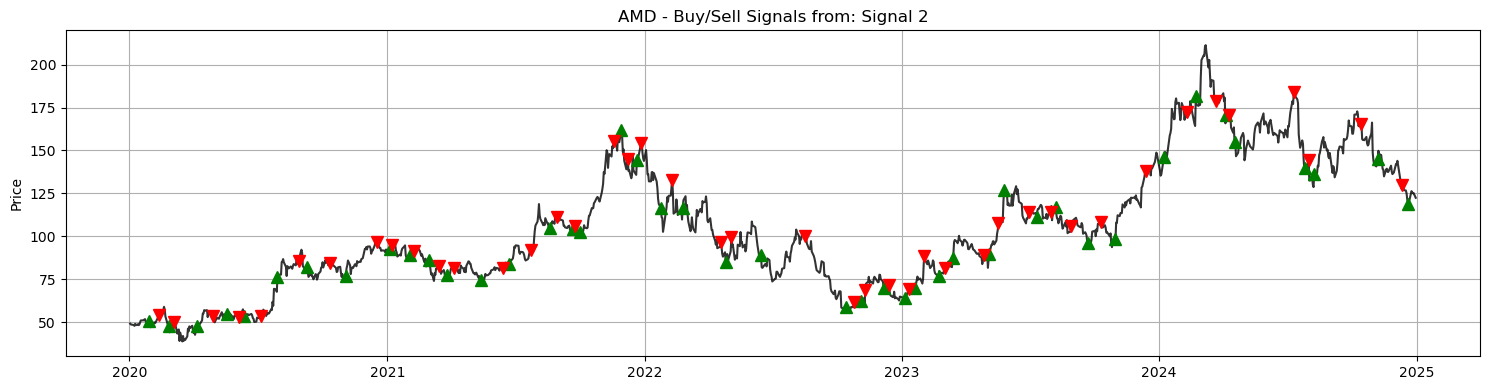

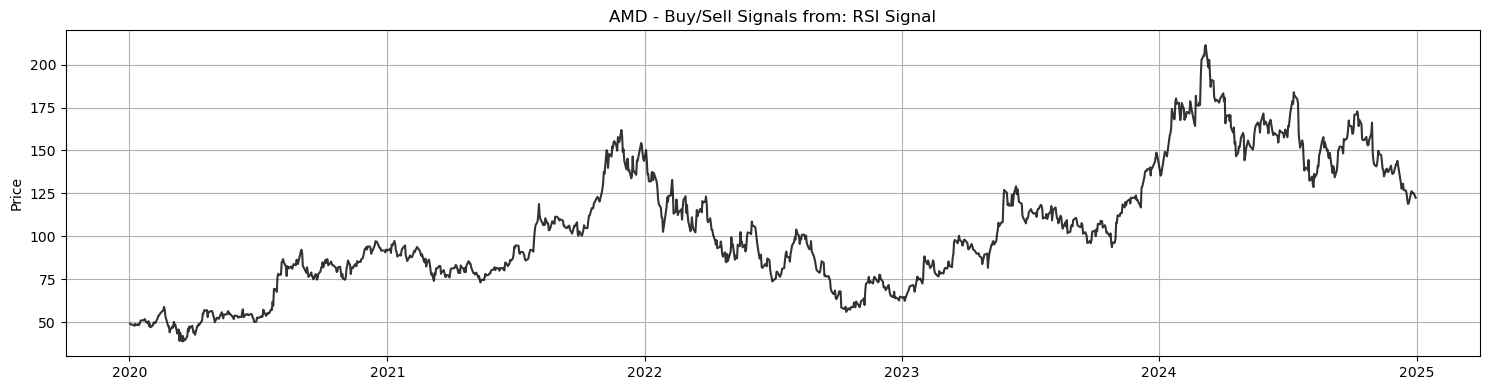

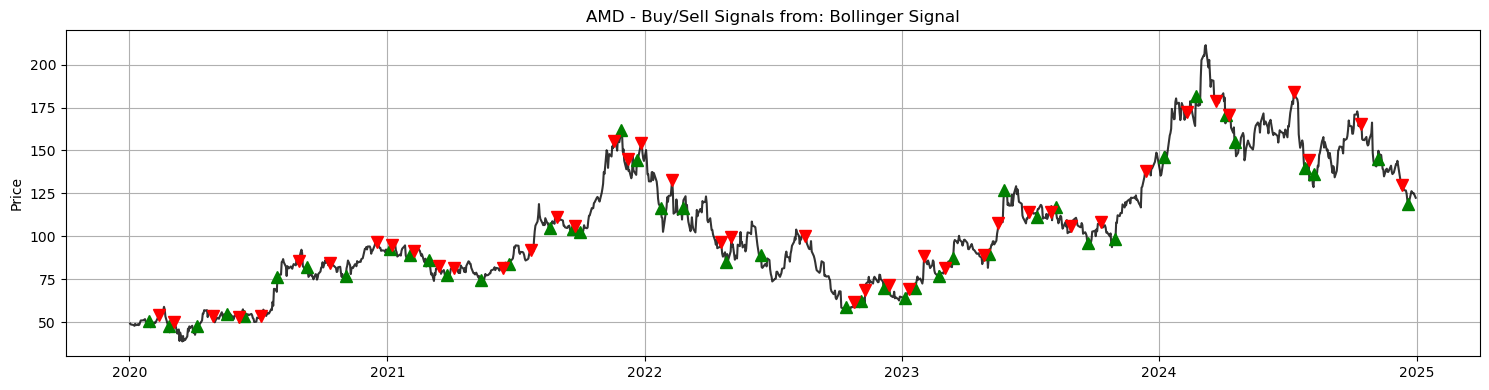

In [14]:
plot_buy_and_sell_signals(signal['position_change'], test_df_prices, best_ticker, 'Signal 2')
plot_buy_and_sell_signals(signal['rsi_position_change'], test_df_prices, best_ticker, 'RSI Signal')
plot_buy_and_sell_signals(signal['bollinger_position_change'], test_df_prices, best_ticker, 'Bollinger Signal')

**Comparison of Sub-Signals**

1. **Visual Analysis (from the charts):**

* **RSI Signal Only**: For the given parameters, the RSI signal did **not generate any trades** throughout the entire timeframe. This indicates that the optimizer selected RSI thresholds so that they were **never triggered**. In effect, the RSI signal was **disabled**, suggesting it offered no standalone value in AMD’s trading environment.
* **Bollinger Bands Signal Only**: This indicator statistically defines relative price levels. However, in a strong trend, the price can persistently "ride" the upper or lower band. A counter-trend strategy based solely on band touches would typically result in losses. Nevertheless, the Bollinger signal alone proved to be **exremly** effective in capturing mean-reversion trades during volatility spikes.
* **Combined Signal (Signal 2)**: While originally designed as a confirmation system, the AMD trading chart shows that the combined signal's entry points were functionally identical to the Bollinger Band entries. This is because the RSI contributed no active signals, making the combination rely entirely on the Bollinger logic. Even so, the entry points were exceptionally precise — typically occurring after sharp drops to the lower band, as seen in early 2020 and late 2022. This still provided strong performance despite the RSI’s inactivity.

2. **Strategic Logic Analysis:**

* The strategy's intended strength lies in its **"confirmation"** mechanism. Bollinger Bands serve as a **"volatility filter"**, identifying statistically extreme price movements. RSI was meant to act as a **"momentum confirmer"**, signaling that market sentiment had reached exhaustion.
* However, in this case, the optimization process selected RSI parameters that **avoided generating any signals at all**. As a result, all trades were triggered solely by the Bollinger condition. Interestingly, this simplified structure still performed strongly, revealing that **RSI confirmation was unnecessary** for high-quality trade filtering in AMD’s market regime.

3. **Quantitative Results Analysis:**

* The final performance table supports this conclusion. For AMD, the combined Signal 2 strategy achieved a **cumulative return of 96.36** and a **Sharpe Ratio of 2.67**. In contrast, the "Buy and Hold" strategy returned just **1.49** with a Sharpe Ratio of **0.61**.
* Since RSI was inactive, we can confidently infer that **the entire return profile was driven by the Bollinger Bands logic alone**. This suggests that in this scenario, combining RSI provided no measurable benefit — and may have even reduced signal frequency had it been active.

For the sake of cmopletion we will **still** include the RSI signal in our Signal 2, since it doesn't generate any negative drawback when for the chosen parameters, it's not active at all on the assessment data set.

## Signal 3: Donchian Channel with ADX

#### 3.A) Define signal

In [15]:
def signal03(prices, adx_window_length, adx_threshhold, donchian_window_length):

    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0

    adx = compute_adx(prices, adx_window_length)
    donchian_sig = donchian_signals(prices, donchian_window_length)
    donchian_sig_array = np.asarray(donchian_sig['signal'])

    position = np.zeros(len(prices), dtype=float)
    holding = 0
    for i in range(len(prices)):
        if np.isnan(adx[i]):
            continue
        if holding == 0 and donchian_sig_array[i] == 1 and adx[i] > adx_threshhold:
            holding = 1
        elif holding == 1 and donchian_sig_array[i] == 0 and adx[i] > adx_threshhold:
            holding = 0
        position[i] = holding

    signals['signal'] = position
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['donchian_position_change'] = donchian_sig['position_change']
    signals.iloc[0, signals.columns.get_loc('position_change')] = 0

    return signals

#### 3.B) Gridsearch best Parameters

**Parameter Grid Rationale with Literature References**

The parameter grid for this strategy is based on well-established principles for trend-following and breakout systems.

* **For Donchian Channel:** The Donchian Channel was popularized by the legendary trader Richard Dennis and the "Turtle Traders." The classic system used a **20-day** breakout for entry. Our grid for `donchian_window_length` (10-20 days) explores this classic value and shorter-term variations, which can be more responsive in modern, faster-moving markets.

* **For Average Directional Index (ADX):** The ADX was developed by J. Welles Wilder Jr., who also created the RSI. The standard look-back period is **14 days**. A common rule of thumb is that an ADX value **above 25** indicates a strong trend. Our grid for `adx_window_length` (10-20) and `adx_threshhold` (20-30) is constructed directly around these widely accepted standard parameters to find the optimal balance between trend sensitivity and noise filtering for each asset.


In [16]:
param_grid = {
    'adx_window_length': [10, 12, 14, 16, 18, 20],
    'adx_threshhold': [20, 22, 25, 26, 28, 30],
    'donchian_window_length': [10, 12, 14, 16, 18, 20],
}

all_best_params = {}
for ticker in tickers:
    prices = test_df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal03, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for TSLA ===
   adx_window_length  adx_threshhold  donchian_window_length     cumret  b&h cumret    sharpe  b&h sharpe
0                 12              22                      10  38.195686   13.552015  1.907435    1.134808
1                 10              22                      10  40.477675   13.552015  1.894104    1.134808
2                 10              20                      10  37.410402   13.552015  1.853967    1.134808

=== Results for AAPL ===
   adx_window_length  adx_threshhold  donchian_window_length    cumret  b&h cumret    sharpe  b&h sharpe
0                 12              22                      10  3.424086    2.464475  1.686375    0.945262
1                 14              20                      10  3.188254    2.464475  1.678081    0.945262
2                 12              22                      12  3.085440    2.464475  1.664870    0.945262

=== Results for AMD ===
   adx_window_length  adx_threshhold  donchian_window_length    cumret  b&h cum

#### 3.C) Evaluate parameters on test set

In [17]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal03(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}

df_test_results = pd.DataFrame.from_dict(test_results)
df_test_results

,TSLA,AAPL,AMD,^GSPC
Strategy Cumulative Return,38.195686,3.424086,4.529146,1.159615
BuyHold Cumulative Return,13.552015,2.464475,1.493686,0.813140
Strategy Sharpe,1.907435,1.686375,1.134222,1.404328
BuyHold Sharpe,1.134808,0.945262,0.611055,0.666648
Sharpe Delta,0.772626,0.741113,0.523167,0.737680
Strategy Max Drawdown,0.337354,0.162422,0.286481,0.096045
BuyHold Max Drawdown,0.736322,0.314273,0.654499,0.339250
Strategy Volatility,0.435846,0.187429,0.358379,0.114736
BuyHold Volatility,0.671894,0.316891,0.524764,0.213473


In [18]:
best_ticker = 'TSLA' #Change this manually on what tikcer works best with the signal
print(f"\n=== Best parameters for Signal 3 / {best_ticker} combination ===")
print(all_best_params[best_ticker])


=== Best parameters for Signal 3 / TSLA combination ===
{'adx_window_length': 12, 'adx_threshhold': 22, 'donchian_window_length': 10}


#### 3.D) Analyisis and interpretation

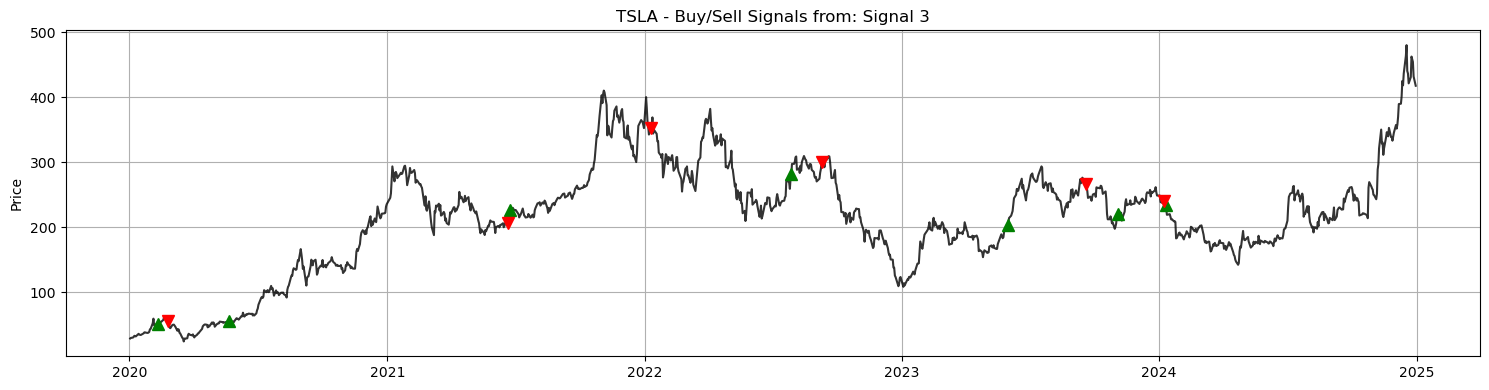

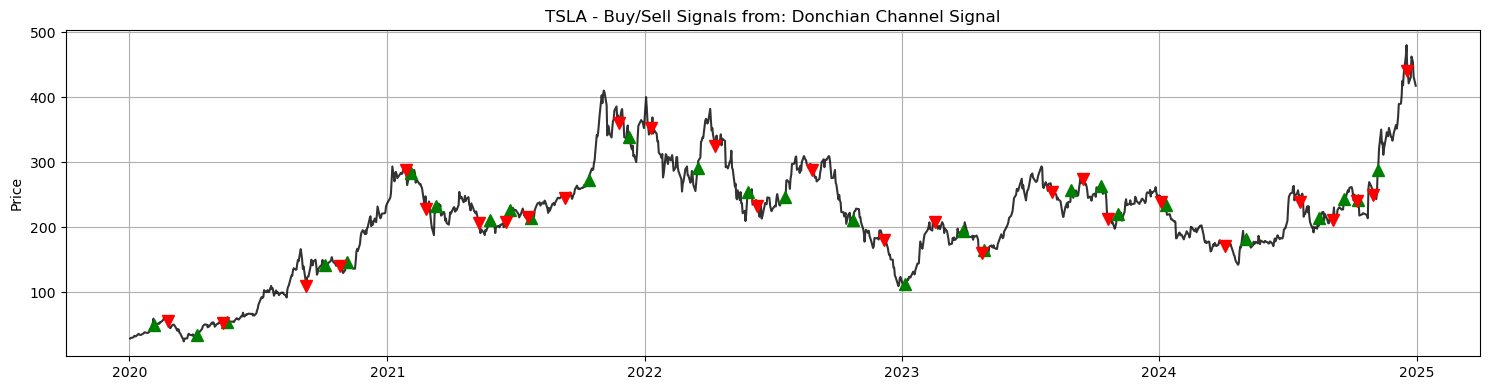

In [19]:
plot_buy_and_sell_signals(signal['position_change'], test_df_prices, best_ticker, 'Signal 3')
plot_buy_and_sell_signals(signal['donchian_position_change'], test_df_prices, best_ticker, 'Donchian Channel Signal')

**Comparison of Sub-Signals**

An analysis of the TSLA stock charts and performance data reveals that **the combined signal (Signal 3), which uses ADX as a trend filter, creates a much more robust and effective strategy than using the Donchian Channel breakout signal alone.**

1.  **Visual Analysis (from the charts):**
    * **Donchian Channel Signal Only:** The "Donchian Channel Signal" chart shows a high number of trading signals. While it successfully identifies many breakout moves, it is also susceptible to "whipsaws" during choppy, non-trending periods. It will generate a buy signal on any new high, even if it's a false breakout with no underlying trend strength, leading to quick reversals and losses.
    * **Combined Signal (Signal 3):** The chart for the combined signals shows significantly fewer trades. The buy and sell points are concentrated in periods of strong, directional price movement (e.g., the rallies in late 2021 and late 2023). Many of the false breakouts seen in the Donchian-only chart have been successfully filtered out.

2.  **Strategic Logic Analysis:**
    * The success of the combined strategy comes from its **trend confirmation mechanism**. The Donchian Channel acts as the primary **"entry trigger,"** identifying potential breakout opportunities. The ADX then serves as a crucial **"trend filter."**
    * A trade is only executed when the Donchian Channel signals a breakout *and* the ADX confirms that a strong, directional trend is in place. This prevents the strategy from taking trades based on price spikes that occur in weak or sideways markets.

3.  **Quantitative Results Analysis:**

    * The in-sample grid search results demonstrate this synergy. For TSLA, the best-performing parameter set (`adx_window_length`: 12, `adx_threshhold`: 22, `donchian_window_length`: 10) yielded a Sharpe Ratio of **1.907**.
    * The visual evidence of numerous whipsaw trades on its chart strongly suggests its risk-adjusted return would be significantly lower. Therefore, adding the ADX filter is critical for improving the signal quality and overall profitability of the breakout strategy.